In [2]:
pip install opencv-contrib-python

   ---------------------------------------- 0.0/46.2 MB ? eta -:--:--
   ------- -------------------------------- 9.2/46.2 MB 51.8 MB/s eta 0:00:01
   ----------------- ---------------------- 20.7/46.2 MB 54.5 MB/s eta 0:00:01
   ------------------------- -------------- 29.6/46.2 MB 52.1 MB/s eta 0:00:01
   ------------------------------ --------- 35.1/46.2 MB 43.7 MB/s eta 0:00:01
   --------------------------------- ------ 38.3/46.2 MB 45.0 MB/s eta 0:00:01
   --------------------------------- ------ 38.3/46.2 MB 45.0 MB/s eta 0:00:01
   ---------------------------------------  46.1/46.2 MB 32.3 MB/s eta 0:00:01
   ---------------------------------------- 46.2/46.2 MB 28.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install tensorflow-cpu

   ---------------------------------------- 0.0/376.0 MB ? eta -:--:--
   - -------------------------------------- 10.0/376.0 MB 47.8 MB/s eta 0:00:08
   - -------------------------------------- 14.7/376.0 MB 51.1 MB/s eta 0:00:08
   -- ------------------------------------- 21.0/376.0 MB 36.8 MB/s eta 0:00:10
   -- ------------------------------------- 21.0/376.0 MB 36.8 MB/s eta 0:00:10
   -- ------------------------------------- 21.0/376.0 MB 36.8 MB/s eta 0:00:10
   -- ------------------------------------- 22.0/376.0 MB 19.9 MB/s eta 0:00:18
   --- ------------------------------------ 30.4/376.0 MB 20.3 MB/s eta 0:00:18
   ---- ----------------------------------- 40.6/376.0 MB 23.9 MB/s eta 0:00:15
   ---- ----------------------------------- 44.0/376.0 MB 25.0 MB/s eta 0:00:14
   ---- ----------------------------------- 46.1/376.0 MB 23.5 MB/s eta 0:00:15
   ----- ---------------------------------- 48.2/376.0 MB 21.9 MB/s eta 0:00:15
   ----- ---------------------------------- 53.7/

# 1. Import Essential Libraries and Functions

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

import cv2
import os
import shutil

# 2. Import Dataset

In [9]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return data

In [3]:
train = get_training_data('Data/chest_xray/train')
test = get_training_data('Data/chest_xray/test')
val = get_training_data('Data/chest_xray/val')

# 3. Dataset Profiling

Text(0.5, 1.0, 'NORMAL')

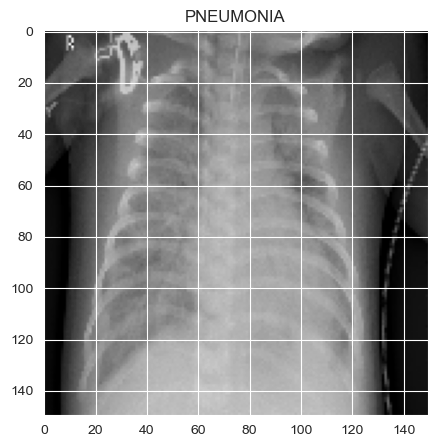

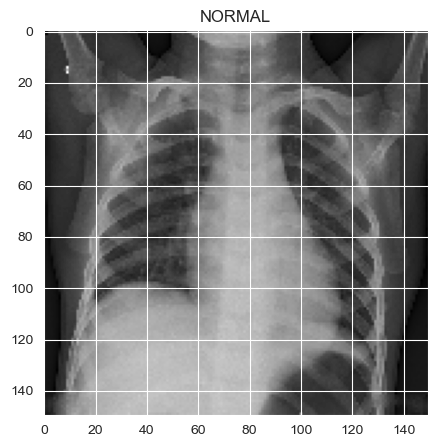

In [14]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

Number of pneumonia samples for training: 3875
Number of normal samples for training: 1341


<Axes: xlabel='count'>

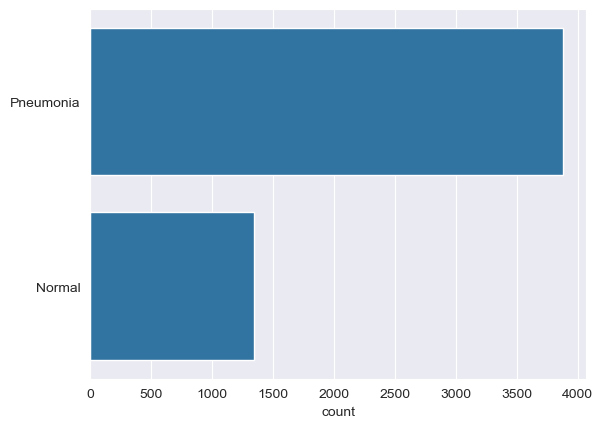

In [4]:
l = []
count_p = 0
count_n = 0
for i in train:
    if(i[1] == 0):
        l.append("Pneumonia")
        count_p += 1
    else:
        l.append("Normal")
        count_n += 1
print("Number of pneumonia samples for training:", count_p)
print("Number of normal samples for training:", count_n)
sns.set_style('darkgrid')
sns.color_palette()
sns.countplot(l)       

In [5]:
sdir=r'Data/chest_xray'
categories=['test', 'train', 'val']
for category in categories:
    category_path=os.path.join(sdir, category)
    filepaths=[]
    labels=[]
    classlist=os.listdir(category_path)
    for klass in classlist:
        classpath=os.path.join(category_path,klass)
        flist=os.listdir(classpath)        
        for f in flist:
            fpath=os.path.join(classpath,f)
            filepaths.append(fpath)
            labels.append(klass)
    Fseries=pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels')
    if category=='test':
        test_df=pd.concat([Fseries, Lseries], axis=1)
    elif category=='train':
        train_df=pd.concat([Fseries, Lseries], axis=1)
    else:
        valid_df=pd.concat([Fseries, Lseries], axis=1)        

print (train_df.head())
print('train_df length: ', len(train_df), ' test_df length: ', len(test_df), '  valid_df length: ', len(valid_df))
print (train_df['labels'].value_counts())

                                        filepaths  labels
0  Data/chest_xray\train\NORMAL\IM-0115-0001.jpeg  NORMAL
1  Data/chest_xray\train\NORMAL\IM-0117-0001.jpeg  NORMAL
2  Data/chest_xray\train\NORMAL\IM-0119-0001.jpeg  NORMAL
3  Data/chest_xray\train\NORMAL\IM-0122-0001.jpeg  NORMAL
4  Data/chest_xray\train\NORMAL\IM-0125-0001.jpeg  NORMAL
train_df length:  5216  test_df length:  624   valid_df length:  16
labels
PNEUMONIA    3875
NORMAL       1341
Name: count, dtype: int64


Dataset is highly imbalanced with much more Pneumonia samples as compared to Normal samples and thus data augmentation is required to reduce biasness. synthetic minority over-sampling technique (SMOTE) used to balance dataset.

# 4. Data Augmentation (SMOTE)

In [6]:
working_dir=r'./Data/'
aug_dir=os.path.join(working_dir, 'augment')
if os.path.isdir(aug_dir):
    shutil.rmtree(aug_dir)
os.mkdir(aug_dir)
for label in train_df['labels'].unique():
    dir_path=os.path.join(aug_dir,label)    
    os.mkdir(dir_path)
print(os.listdir(aug_dir))

['NORMAL', 'PNEUMONIA']


New folder in the working directory is first created to store augmented images

In [7]:
target = 3875 # set the target count for each class in df

gen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images

groups = train_df.groupby('labels') # group by class
for label in train_df['labels'].unique():  # for every class               
    group = groups.get_group(label)  # a dataframe holding only rows with the specified label 
    sample_count = len(group)   # determine how many samples there are in this class  
    if sample_count < target: # if the class has less than target number of images
        aug_img_count = 0
        delta = target-sample_count  # number of augmented images to create
        target_dir=os.path.join(aug_dir, label)  # define where to write the images    
        aug_gen=gen.flow_from_dataframe(group, 
                                        x_col = 'filepaths', 
                                        y_col = None,  
                                        class_mode = None, 
                                        batch_size = 1,
                                        shuffle = False, 
                                        save_to_dir = target_dir, 
                                        save_prefix = 'aug-',
                                        save_format = 'jpg')
        while aug_img_count < delta:
            images = next(aug_gen)            
            aug_img_count += len(images)

Found 1341 validated image filenames.


Generation of augmented images for the normal samples and saved in the created directory

In [8]:
aug_fpaths = []
aug_labels = []
classlist = os.listdir(aug_dir)
for klass in classlist:
    classpath = os.path.join(aug_dir, klass)     
    flist = os.listdir(classpath)    
    for f in flist:        
        fpath = os.path.join(classpath, f)         
        aug_fpaths.append(fpath)
        aug_labels.append(klass)
Fseries = pd.Series(aug_fpaths, name = 'filepaths')
Lseries = pd.Series(aug_labels, name = 'labels')
aug_df = pd.concat([Fseries, Lseries], axis = 1)
print('length of aug_df: ', len(aug_df))
train_df = pd.concat([train_df, aug_df], axis = 0).reset_index(drop = True)
train_df = train_df.sample(frac = 1.0, replace = False, random_state = 123, axis = 0).reset_index(drop = True)
print ('length of train_df is: ', len(train_df)) 
print (train_df['labels'].value_counts())

length of aug_df:  2534
length of train_df is:  7750
labels
PNEUMONIA    3875
NORMAL       3875
Name: count, dtype: int64


Number of both classes of samples in the directory are enumerated and are shown to be exactly balanced at 50-50 ratio.

In [10]:
augmented = get_training_data('Data/augment')

Number of pneumonia samples for training: 0
Number of normal samples for training: 2534


<Axes: xlabel='count'>

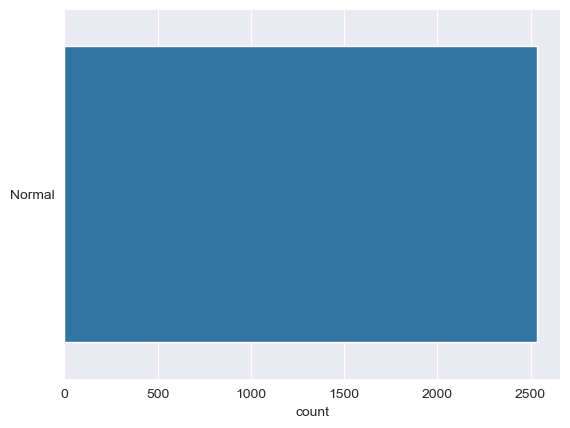

In [11]:
l = []
count_p = 0
count_n = 0
for i in augmented:
    if(i[1] == 0):
        l.append("Pneumonia")
        count_p += 1
    else:
        l.append("Normal")
        count_n += 1
print("Number of pneumonia samples for training:", count_p)
print("Number of normal samples for training:", count_n)
sns.set_style('darkgrid')
sns.countplot(l)       

Number of augmented images generated and imported as well as its class are checked.

In [12]:
train_augmented = train + augmented

Number of pneumonia samples for training: 3875
Number of normal samples for training: 3875


<Axes: xlabel='count'>

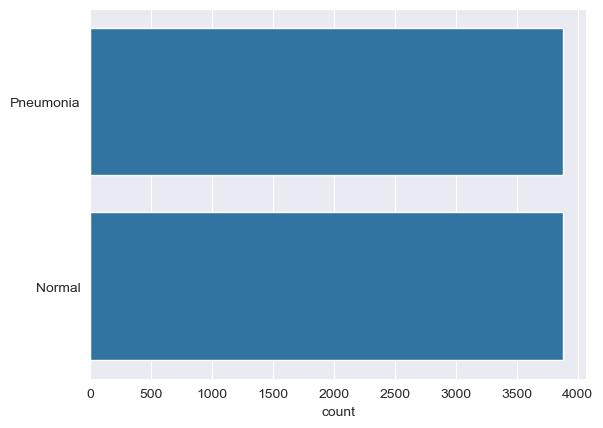

In [13]:
l = []
count_p = 0
count_n = 0
for i in train_augmented:
    if(i[1] == 0):
        l.append("Pneumonia")
        count_p += 1
    else:
        l.append("Normal")
        count_n += 1
print("Number of pneumonia samples for training:", count_p)
print("Number of normal samples for training:", count_n)
sns.set_style('darkgrid')
sns.countplot(l)       

Both classes of training samples are now balanced and can be used to train model

# 5. Data Pre-Processing

In [15]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train_augmented:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)
    
for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [16]:
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

Image greyscaled and normalised

In [17]:
# resize data for deep learning 
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [18]:
x_train_gen = gen.fit(x_train)

In [19]:
x_train_gen

# 6. ANN Model

In [20]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = optimizers.Adam() , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

C:\Users\nigel.ang\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 38, 38, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 38, 38, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 38, 38, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 19, 19, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 19, 19, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 19, 19, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 19, 19, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 10, 10, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 10, 10, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6400)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       819,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴─────────────

 Total params: 1,246,401 (4.75 MB)

 Trainable params: 1,245,313 (4.75 MB)

 Non-trainable params: 1,088 (4.25 KB)

In [21]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [22]:
history = model.fit(gen.flow(x_train,y_train, batch_size = 32) ,epochs = 12 , validation_data = gen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

C:\Users\nigel.ang\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.8315 - loss: 0.5808 - val_accuracy: 0.5000 - val_loss: 1.8149 - learning_rate: 0.0010
Epoch 2/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 325s 1s/step - accuracy: 0.9235 - loss: 0.2048 - val_accuracy: 0.5000 - val_loss: 9.5243 - learning_rate: 0.0010
Epoch 3/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9350 - loss: 0.1726
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
243/243 ━━━━━━━━━━━━━━━━━━━━ 327s 1s/step - accuracy: 0.9350 - loss: 0.1726 - val_accuracy: 0.5000 - val_loss: 13.0084 - learning_rate: 0.0010
Epoch 4/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 286s 1s/step - accuracy: 0.9528 - loss: 0.1260 - val_accuracy: 0.5000 - val_loss: 4.3846 - learning_rate: 3.0000e-04
Epoch 5/12
243/243 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9590 - loss: 0.1142
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
243/243 ━━━━━━━━━━━━━━━━━━━━ 277s 1s/step - accuracy: 0.9590 - loss: 0.1

# 7. Model Validation

In [23]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 233ms/step - accuracy: 0.9508 - loss: 0.1616
Loss of the model is -  0.4831250011920929
20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 290ms/step - accuracy: 0.9508 - loss: 0.1616
Accuracy of the model is -  85.73718070983887 %


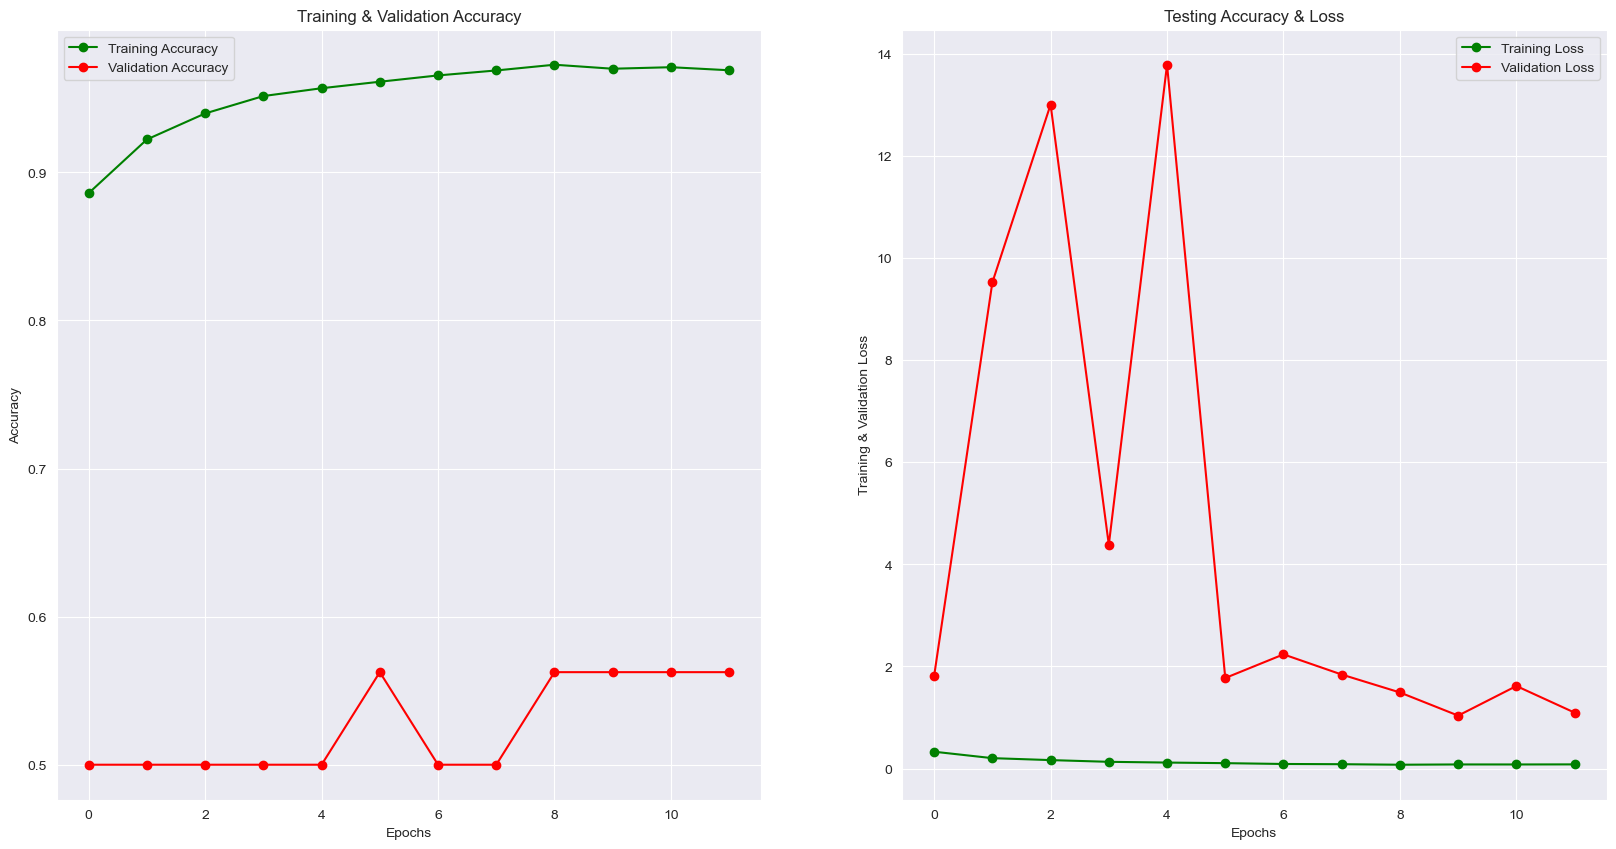

In [24]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [25]:
y_pred_probs = model.predict(x_test)
y_pred_classes = np.argmax(y_pred_probs, axis = 1)
y_pred_classes = y_pred_classes.reshape(1,-1)[0]
y_pred_probs[:20]
#y_pred_classes[:20]
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions[:20]

20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 205ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 175ms/step


array([[0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0]])

In [26]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia (Class 0)','Normal (Class 1)']))

                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.82      0.99      0.90       390
   Normal (Class 1)       0.97      0.64      0.77       234

           accuracy                           0.86       624
          macro avg       0.90      0.81      0.83       624
       weighted avg       0.88      0.86      0.85       624



<Axes: >

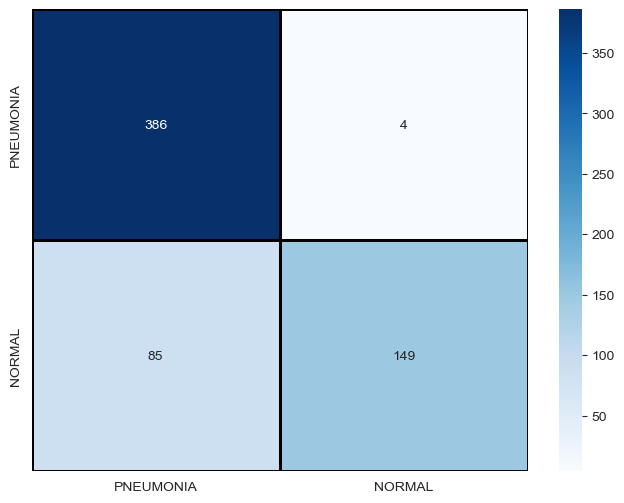

In [27]:
cm = confusion_matrix(y_test,predictions)
plt.figure(figsize = (8,6))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

Model has a very high overall accuracy of 85.7% with a high precision of normal samples at 0.97. This high precision for normal x-rays is highly desirable as false negatives (false undiagnosed pneumonua) can lead to misdiagnosis and potentially administer treatment at a much later time that could result in greater complications due to pneumonia.